In [1]:
# !pip install hydra-core

  Using cached hydra_core-1.3.2-py3-none-any.whl.metadata (5.5 kB)
     ---------------------------------------- 0.0/117.0 kB ? eta -:--:--
     --- ------------------------------------ 10.2/117.0 kB ? eta -:--:--
     --------- --------------------------- 30.7/117.0 kB 435.7 kB/s eta 0:00:01
     ---------------------- -------------- 71.7/117.0 kB 491.5 kB/s eta 0:00:01
     ------------------------------------ 117.0/117.0 kB 757.4 kB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
   ---------------------------------------- 0.0/154.5 kB ? eta -:--:--
   ----------------------------- ---------- 112.6/154.5 kB 3.3 MB/s eta 0:00:01
   ---------------------------------------- 154.5/154.5 kB 1.9 MB/s eta 0:00:00
   ---------------------------------------- 0.0/79.5 kB ? eta -:--:--
   ---------------------------------------- 79.5/79.5 kB ? eta 0:00:00
  Created wheel for antlr4-python3-runtime: filename=antlr4_python3_runt

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
qpd 0.4.4 requires antlr4-python3-runtime<4.12,>=4.11.1, but you have antlr4-python3-runtime 4.9.3 which is incompatible.


In [42]:
import pandas as pd
import numpy as  np
import pycaret
from pycaret.regression import *
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px

import mlflow
import mlflow.sklearn
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import os
import hydra
from omegaconf import DictConfig
from hydra.experimental import compose, initialize_config_dir

## Data preprocessing

1. Drop columns
2. Drop null
3. Filter rows to remove outliers
4. replace values to binary
5. change datatypes

# Pycaret
1. Target is price
2. train size: 0.8
3. normalize = True
4. rm
5. 10 kfold

In [43]:
hydra.core.global_hydra.GlobalHydra.instance().clear()

All parameters in process_home.yaml: {'data': {'raw': '../../data/raw/01_homely_resort_listing.csv', 'ppath': '../../data/processed/'}, 'setup': {'target': 'price', 'train_size': 0.8, 'norm': True, 'session': 123, 'expname': 'homes_v2', 'fold': 10}}


,Description,Value
0,Session id,123
1,Target,price
2,Target type,Regression
3,Original data shape,"(1424, 24)"
4,Transformed data shape,"(1424, 46)"
5,Transformed train set shape,"(1139, 46)"
6,Transformed test set shape,"(285, 46)"
7,Numeric features,19
8,Categorical features,4
9,Preprocess,True


Numeric features: ['accommodates', 'availability_30', 'bathrooms', 'bedrooms', 'beds', 'calculated_host_listings_count', 'guests_included', 'host_is_superhost', 'host_listings_count', 'instant_bookable', 'latitude(North)', 'longitude(East)', 'maximum_nights', 'number_of_reviews', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_rating', 'review_scores_value']
Categorical features: ['bed_type', 'cancellation_policy', 'property_type', 'room_type']


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
catboost,CatBoost Regressor,87.2789,28089.9447,162.1283,0.6605,0.4823,0.4597,1.0570
lightgbm,Light Gradient Boosting Machine,93.2280,31653.3846,172.7151,0.6163,0.5113,0.5069,0.1530
gbr,Gradient Boosting Regressor,93.8469,31931.0949,173.4047,0.6094,0.5411,0.5169,0.1700
rf,Random Forest Regressor,98.0164,34100.9337,179.6227,0.5870,0.5118,0.5598,0.3880
et,Extra Trees Regressor,100.8297,36114.3053,183.2243,0.5697,0.5233,0.5560,0.2960
xgboost,Extreme Gradient Boosting,101.2634,37260.7367,188.1406,0.5284,0.5588,0.5690,0.1380
br,Bayesian Ridge,114.4098,40961.6075,195.6708,0.5091,0.7398,0.7294,0.0510
en,Elastic Net,109.9975,42049.6375,197.6518,0.5057,0.6559,0.6663,0.0580
lasso,Lasso Regression,115.5171,41241.3596,196.4374,0.5037,0.7565,0.7454,0.0610
llar,Lasso Least Angle Regression,115.5172,41241.2390,196.4371,0.5037,0.7566,0.7455,0.0550


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,CatBoost Regressor,70.7399,14623.4627,120.9275,0.6738,0.4682,0.4592


      accommodates  availability_30  bathrooms  bed_type  bedrooms  beds  \
4560             6               23        1.0  Real Bed       2.0   2.0   
5821             4                6        1.0  Real Bed       1.0   2.0   
3823             4                5        2.0  Real Bed       1.0   2.0   
3780             4               16        1.0  Real Bed       1.0   1.0   
1428             3                7        1.0  Real Bed       1.0   1.0   
...            ...              ...        ...       ...       ...   ...   
5327             2               30        1.0  Real Bed       1.0   1.0   
1770             4               16        1.0  Real Bed       1.0   2.0   
4315            12               22        2.0  Real Bed       4.0  10.0   
4013             2               28        1.0  Real Bed       1.0   1.0   
2539             6               28        3.5  Real Bed       4.0   4.0   

      calculated_host_listings_count cancellation_policy  guests_included  \
4560      

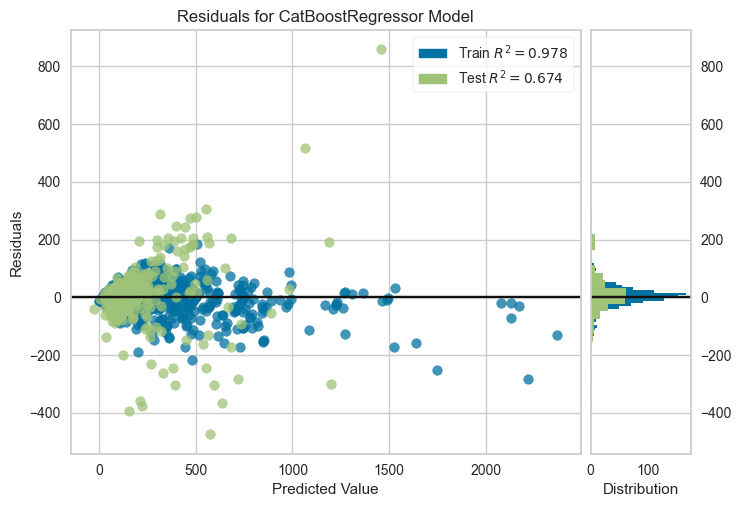

Transformation Pipeline and Model Successfully Saved
Transformation Pipeline and Model Successfully Loaded
Pipeline(memory=FastMemory(location=C:\Users\ZUDEAN~1\AppData\Local\Temp\joblib),
         steps=[('numerical_imputer',
                 TransformerWrapper(include=['accommodates', 'availability_30',
                                             'bathrooms', 'bedrooms', 'beds',
                                             'calculated_host_listings_count',
                                             'guests_included',
                                             'host_is_superhost',
                                             'host_listings_count',
                                             'instant_bookable',
                                             'latitude(North)',
                                             'longitude(East)',
                                             'm...
                                    transformer=OneHotEncoder(cols=['bed_type',
              

2024/02/23 23:20:15 INFO mlflow.tracking.fluent: Experiment with name 'homes_final' does not exist. Creating a new experiment.
Successfully registered model 'homes_final'.
2024/02/23 23:20:18 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: homes_final, version 1
Created version '1' of model 'homes_final'.


In [44]:
def process_train():
    root_directory = "C:/Users/Zude Ang/mlops_assgn"

    config_dir = os.path.normpath(os.path.join(root_directory,"config","process"))

    initialize_config_dir(config_dir=config_dir)
    config = compose(config_name="process_home")
    print('All parameters in process_home.yaml: ' + str(config))

    home = pd.read_csv(config.data.raw)
    home['price'] = home['price'].replace('[^\d.]','',regex=True)

    home = home.drop(columns=['Unnamed: 25', 'has_availability', 'amenities'])
    home =home.dropna()
    
    #replacing string to binary
    home['host_is_superhost'] = home['host_is_superhost'].replace({'t': 1, 'f': 0})
    home['instant_bookable'] = home['instant_bookable'].replace({'t': 1, 'f': 0})

    home = home[home['host_listings_count'] < 50]
    home = home[home['maximum_nights'] <= 365]
    #replacing string with categorical values
    home['bed_type'] = home['bed_type'].astype('object')
    home['cancellation_policy'] = home['cancellation_policy'].astype('object')
    home['property_type'] = home['property_type'].astype('object')
    home['room_type'] = home['room_type'].astype('object')
    
    home['price'] = home['price'].astype(float).astype(int)

    home_setup = setup(
          data = home,
        target=config.setup.target,
        train_size = config.setup.train_size,
        normalize = config.setup.norm,
        session_id = config.setup.session,
        experiment_name = config.setup.expname,
        fold = config.setup.fold
    )

    print(f'Numeric features: {home_setup._fxs["Numeric"]}')
    print(f'Categorical features: {home_setup._fxs["Categorical"]}')

    data = home_setup.get_config('dataset_transformed')
    file_name = 'home_processed.csv'

    fullfp = os.path.join(config.data.ppath, file_name)
    data.to_csv(fullfp, index=False)

    # print(f'Data written at {fullfp}.')

    best = compare_models()

    #since the tuned model is the same as the original model, tuning will be skipped
    preds = predict_model(best)
    print(preds)

    plot_model(best, plot='residuals')

    final = finalize_model(best)
    save_model(final, 'homely_resort')
    load_pipeline = load_model('homely_resort')
    print(load_pipeline)

    mlflow.set_experiment(experiment_id="239846606708982393")
    mlflow.set_tracking_uri("http://127.0.0.1:5000")

    y_true = preds['price']
    y_pred = preds['prediction_label']
    
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    r2 = r2_score(y_true, y_pred)
    mlflow.end_run()
    
    
    # Start an MLflow run
    with mlflow.start_run() as run:
        mlflow.log_param('train_size', 0.8)
        mlflow.log_param('normalize', True)
        mlflow.log_param('fold',10)
        
        # Log metrics
        mlflow.log_metric('MAE', mae)
        mlflow.log_metric('MSE', mse)
        mlflow.log_metric('RMSE', rmse)
        mlflow.log_metric('R2', r2)
        
        # Set the experiment name (note: this should be set before logging parameters)
        mlflow.set_experiment('homes_final')
        mlflow.log_param('experiment_name', 'homes_final')
        mlflow.log_param('run_id', run.info.run_id)
    
    
        # Log the Sklearn model
        mlflow.sklearn.log_model(sk_model=best, registered_model_name='homes_final', artifact_path='sk_model')
    
    
process_train()